## Call a prompt flow with Agents using Haystack Pipelines & Components
--- 

In this example, we create a simple agent that we ask a question from. The agent uses that question and invokes a prompt flow that get's the response from an LLM and evaluates the response using an LLM as a judge. It follows the steps below:

1. Invoke the agent to generate a synthetic question 

1. The output of the agent is fed as input to the prompt flow (the LLM as a judge prompt flow. For more information on how this is created, view [here](Bedrock_Prompt_Flows_Examples/bedrock_prompt_flows_simple_example.ipynb))

1. The prompt flow ingests the agent response, and parses it to an LLM call that generates a response to the question, which is then evaluated by another LLM.

This is all done via a haystack pipeline where an agent is treated as a component and a prompt flow is treated as another component. These are custom components that are created.

In [1]:
!python3 -m pip install --upgrade -q botocore
!python3 -m pip install --upgrade -q boto3
!python3 -m pip install --upgrade -q awscli

In [36]:
import boto3
import json
import time
import uuid
import pprint
import logging
print(boto3.__version__)

1.35.54


In [3]:
# setting logger
logging.basicConfig(format='[%(asctime)s] p%(process)s {%(filename)s:%(lineno)d} %(levelname)s - %(message)s', level=logging.INFO)
logger = logging.getLogger(__name__)

In [4]:
# getting boto3 clients for required AWS services
sts_client = boto3.client('sts')
iam_client = boto3.client('iam')
lambda_client = boto3.client('lambda')
bedrock_agent_client = boto3.client('bedrock-agent')
bedrock_agent_runtime_client = boto3.client('bedrock-agent-runtime')

[2024-11-05 15:28:42,186] p44184 {credentials.py:1278} INFO - Found credentials in shared credentials file: ~/.aws/credentials


In [5]:
session = boto3.session.Session()
region = session.region_name
account_id = sts_client.get_caller_identity()["Account"]
region, account_id

('us-east-1', '015469603702')

In [8]:
# configuration variables
suffix = f"{region}-{account_id}"
agent_name = "simple-qna-agent"
agent_bedrock_allow_policy_name = f"{agent_name}-ba-{suffix}"
agent_role_name = f'AmazonBedrockExecutionRoleForAgents_{agent_name}'
agent_foundation_model = "anthropic.claude-3-sonnet-20240229-v1:0"
agent_description = "Agent for answering user questions"
agent_instruction = "You are an agent for answering simple science questions"

In [9]:
# Create IAM policies for agent
bedrock_agent_bedrock_allow_policy_statement = {
    "Version": "2012-10-17",
    "Statement": [
        {
            "Sid": "AmazonBedrockAgentBedrockFoundationModelPolicy",
            "Effect": "Allow",
            "Action": "bedrock:InvokeModel",
            "Resource": [
                f"arn:aws:bedrock:{region}::foundation-model/{agent_foundation_model}"
            ]
        }
    ]
}

bedrock_policy_json = json.dumps(bedrock_agent_bedrock_allow_policy_statement)

agent_bedrock_policy = iam_client.create_policy(
    PolicyName=agent_bedrock_allow_policy_name,
    PolicyDocument=bedrock_policy_json
)
# Create IAM Role for the agent and attach IAM policies
assume_role_policy_document = {
    "Version": "2012-10-17",
    "Statement": [{
          "Effect": "Allow",
          "Principal": {
            "Service": "bedrock.amazonaws.com"
          },
          "Action": "sts:AssumeRole"
    }]
}

assume_role_policy_document_json = json.dumps(assume_role_policy_document)
agent_role = iam_client.create_role(
    RoleName=agent_role_name,
    AssumeRolePolicyDocument=assume_role_policy_document_json
)

# Pause to make sure role is created
time.sleep(10)
    
iam_client.attach_role_policy(
    RoleName=agent_role_name,
    PolicyArn=agent_bedrock_policy['Policy']['Arn']
)

{'ResponseMetadata': {'RequestId': '058d68f3-8683-4905-aaa4-e0faea65c3b6',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'date': 'Tue, 05 Nov 2024 20:29:13 GMT',
   'x-amzn-requestid': '058d68f3-8683-4905-aaa4-e0faea65c3b6',
   'content-type': 'text/xml',
   'content-length': '212'},
  'RetryAttempts': 0}}

In [10]:
response = bedrock_agent_client.create_agent(
    agentName=agent_name,
    agentResourceRoleArn=agent_role['Role']['Arn'],
    description=agent_description,
    idleSessionTTLInSeconds=1800,
    foundationModel=agent_foundation_model,
    instruction=agent_instruction,
)
response

{'ResponseMetadata': {'RequestId': '4a181168-f7d5-41fc-8800-3e9e5dbea87b',
  'HTTPStatusCode': 202,
  'HTTPHeaders': {'date': 'Tue, 05 Nov 2024 20:29:14 GMT',
   'content-type': 'application/json',
   'content-length': '572',
   'connection': 'keep-alive',
   'x-amzn-requestid': '4a181168-f7d5-41fc-8800-3e9e5dbea87b',
   'x-amz-apigw-id': 'Ayj0IHOwoAMEhXA=',
   'x-amzn-trace-id': 'Root=1-672a801a-5eb4b9f617039a2253c43c62'},
  'RetryAttempts': 0},
 'agent': {'agentArn': 'arn:aws:bedrock:us-east-1:015469603702:agent/JJ3TRIIKFH',
  'agentId': 'JJ3TRIIKFH',
  'agentName': 'simple-qna-agent',
  'agentResourceRoleArn': 'arn:aws:iam::015469603702:role/AmazonBedrockExecutionRoleForAgents_simple-qna-agent',
  'agentStatus': 'CREATING',
  'createdAt': datetime.datetime(2024, 11, 5, 20, 29, 14, 152232, tzinfo=tzutc()),
  'description': 'Agent for answering user questions',
  'foundationModel': 'anthropic.claude-3-sonnet-20240229-v1:0',
  'idleSessionTTLInSeconds': 1800,
  'instruction': 'You are 

In [11]:
agent_id = response['agent']['agentId']
agent_id

'JJ3TRIIKFH'

### Create a haystack pipeline
---

In this portion of the notebook, we will create a haystack pipeline. We will implement two components as a part of this pipeline that will be connected with each other: a `BedrockAgent` component and a `BedrockPromptFlow` component.

In [12]:
# For each component, it is essential to know the names of the input and the output. There are several components for various steps
# of the generative AI pipeline that are provided out of the box. This includes components for document stores, embedders, prompt
# builders and generators. You can also build your own component.
!pip install -U pip
!pip install -U haystack
!pip install -U sentence-transformers

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [29]:
## create a random id for session initiator id
session_id:str = str(uuid.uuid1())
session_id

'f0d9b4a8-9bb4-11ef-8e19-168aeb12c116'

In [35]:
response = bedrock_agent_client.prepare_agent(
    agentId=agent_id
)

{'ResponseMetadata': {'RequestId': 'f34c2ba7-3c69-46e6-9a08-60de69de6abb', 'HTTPStatusCode': 202, 'HTTPHeaders': {'date': 'Tue, 05 Nov 2024 20:32:47 GMT', 'content-type': 'application/json', 'content-length': '119', 'connection': 'keep-alive', 'x-amzn-requestid': 'f34c2ba7-3c69-46e6-9a08-60de69de6abb', 'x-amz-apigw-id': 'AykViEokIAMEWcg=', 'x-amzn-trace-id': 'Root=1-672a80ef-5482e49b02d06d5b6d7dafd1'}, 'RetryAttempts': 0}, 'agentId': 'JJ3TRIIKFH', 'agentStatus': 'PREPARING', 'agentVersion': 'DRAFT', 'preparedAt': datetime.datetime(2024, 11, 5, 20, 32, 47, 974936, tzinfo=tzutc())}


In [42]:
logger.info(pprint.pprint(response))

2024-11-05T20:35:27.172554Z [info     ] None                           lineno=1 module=__main__
[2024-11-05 15:35:27,172] p44184 {861432392.py:1} INFO - None


{'ResponseMetadata': {'HTTPHeaders': {'connection': 'keep-alive',
                                      'content-length': '119',
                                      'content-type': 'application/json',
                                      'date': 'Tue, 05 Nov 2024 20:32:47 GMT',
                                      'x-amz-apigw-id': 'AykViEokIAMEWcg=',
                                      'x-amzn-requestid': 'f34c2ba7-3c69-46e6-9a08-60de69de6abb',
                                      'x-amzn-trace-id': 'Root=1-672a80ef-5482e49b02d06d5b6d7dafd1'},
                      'HTTPStatusCode': 202,
                      'RequestId': 'f34c2ba7-3c69-46e6-9a08-60de69de6abb',
                      'RetryAttempts': 0},
 'agentId': 'JJ3TRIIKFH',
 'agentStatus': 'PREPARING',
 'agentVersion': 'DRAFT',
 'preparedAt': datetime.datetime(2024, 11, 5, 20, 32, 47, 974936, tzinfo=tzutc())}


In [43]:
from typing import Dict, Any, List
from haystack import component, Pipeline
from haystack.dataclasses import Document

# create a component for an agent
@component
class BedrockAgent:
    def __init__(self, agent_id: str):
        self.agent_id = agent_id
        self.bedrock_runtime = boto3.client('bedrock-agent-runtime')

    @component.output_types(agent_response=str)
    def run(self, query: str) -> Dict[str, Any]:
        try:
            agentResponse = self.bedrock_runtime.invoke_agent(
                agentId=self.agent_id,
                inputText=query,
                agentAliasId='input-your-agent-alias-id-here',
                sessionId=session_id,
                enableTrace=True, 
                endSession= False
            )
            event_stream = agentResponse['completion']
            logger.info(f"received the event stream: {event_stream}")
            for event in event_stream:        
                if 'chunk' in event:
                    data = event['chunk']['bytes']
                    logger.info(f"Final answer ->\n{data.decode('utf8')}")
                    agent_answer = data.decode('utf8')
                    end_event_received = True
                    # End event indicates that the request finished successfully
                elif 'trace' in event:
                    logger.info(json.dumps(event['trace'], indent=2))
                else:
                    raise Exception("unexpected event.", event)
            logger.info(f"generated question to answer: {response}")
            return {"agent_response": agent_answer}
        except Exception as e:
            raise Exception("An error occurred while the agent was generating a question:", e)

In [44]:
# create a component for a prompt flow
@component
class BedrockPromptFlow:
    def __init__(self, prompt_flow_id: str):
        self.prompt_flow_id = prompt_flow_id
        self.bedrock_runtime = boto3.client('bedrock-agent-runtime')

    @component.output_types(response=str)
    def run(self, input_text: str) -> Dict[str, Any]:
        response = self.bedrock_runtime.invoke_flow(
            flowIdentifier = '5SG8POBN1H',
            flowAliasIdentifier = 'GWRK8I8UYR',
            inputs = [
                { 
                    "content": { 
                        "document": input_text
                    },
                    "nodeName": "Start",
                    "nodeOutputName": "document"
                }
            ]
        )
        event_stream = response["responseStream"]
        for event in event_stream:
            #print(json.dumps(event, indent=2, ensure_ascii=False))
            if "flowOutputEvent" in event:
                evalResponse = json.loads(event["flowOutputEvent"]["content"]["document"])
        if evalResponse:
            evalResponse["modelInvoke"] = 'amazon.titan-text-premier-v1:0'
            evalResponse["modelEval"] = 'anthropic.claude-3-sonnet-20240229-v1:0'
            return {"response": evalResponse}

In [45]:
# Create the pipeline
pipeline = Pipeline()

# Add the components
pipeline.add_component("agent", BedrockAgent(agent_id=agent_id))
pipeline.add_component("prompt_flow", BedrockPromptFlow(prompt_flow_id="5SG8POBN1H"))

# Connect the components
pipeline.connect("agent.agent_response", "prompt_flow.input_text")

🚅 Components
  - agent: BedrockAgent
  - prompt_flow: BedrockPromptFlow
🛤️ Connections
  - agent.agent_response -> prompt_flow.input_text (str)

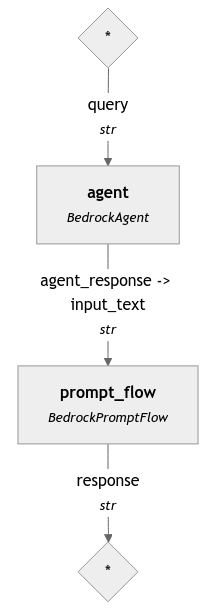

In [46]:
pipeline.show()

In [47]:
# Run the pipeline
result = pipeline.run(
    data={
        "agent": {
            "query": "Generate a complex question on generative AI."
        }
    }
)

# Print the final result
print(result["prompt_flow"]["response"])

2024-11-05T20:35:32.701413Z [info     ] Running component agent        component_name=agent lineno=66 module=haystack.core.pipeline.pipeline
[2024-11-05 15:35:32,701] p44184 {pipeline.py:66} INFO - Running component agent
2024-11-05T20:35:32.850246Z [info     ] received the event stream: <botocore.eventstream.EventStream object at 0x300086750> lineno=24 module=__main__
[2024-11-05 15:35:32,850] p44184 {4108401266.py:24} INFO - received the event stream: <botocore.eventstream.EventStream object at 0x300086750>
2024-11-05T20:35:33.049691Z [info     ] {
  "agentAliasId": "H4RADK4KG2",
  "agentId": "JJ3TRIIKFH",
  "agentVersion": "1",
  "sessionId": "f0d9b4a8-9bb4-11ef-8e19-168aeb12c116",
  "trace": {
    "orchestrationTrace": {
      "modelInvocationInput": {
        "inferenceConfiguration": {
          "maximumLength": 2048,
          "stopSequences": [
            "</function_calls>",
            "</answer>",
            "</error>"
          ],
          "temperature": 0.0,
          "

{'answer-score': 95, 'prompt-score': 90, 'justification': 'The answer provides a comprehensive and technically accurate comparison of GANs, VAEs, and diffusion models, highlighting their strengths, limitations, and potential failure modes. It also addresses the ethical risks associated with generative AI systems in a thoughtful manner. The answer is well-structured, grammatically correct, and aligns with the prompt. However, there are no explicit examples provided, which could have further enhanced the explanation. The prompt is clear, detailed, and sets the context well. It provides specific criteria for the expected answer format and tone. However, it could have been improved by including examples or a more specific role or context.', 'input': 'How do the different architectures and training approaches used in generative adversarial networks (GANs), variational autoencoders (VAEs), and diffusion models impact the types of data distributions they can effectively model? What are the ke

In [49]:
logger.info(pprint.pprint(result["prompt_flow"]["response"]))

2024-11-05T20:37:00.744202Z [info     ] None                           lineno=1 module=__main__
[2024-11-05 15:37:00,744] p44184 {4010925961.py:1} INFO - None


{'answer-score': 95,
 'input': 'How do the different architectures and training approaches used in '
          'generative adversarial networks (GANs), variational autoencoders '
          '(VAEs), and diffusion models impact the types of data distributions '
          'they can effectively model? What are the key strengths and '
          'limitations of each approach in terms of sample quality, diversity, '
          'and potential for mode collapse or other failure modes? '
          'Additionally, as generative AI systems become more powerful and are '
          'applied to domains like synthetic media generation, what are some '
          'of the key ethical risks that need to be carefully considered and '
          'mitigated?',
 'justification': 'The answer provides a comprehensive and technically '
                  'accurate comparison of GANs, VAEs, and diffusion models, '
                  'highlighting their strengths, limitations, and potential '
                  'failure